
Fit Exp1D
=========================================
In this example, we simulate a unidimensional (ground truth) MHP with an exponential kernel.

We then estimate the parameters of this MHP using ASLSD, and compare with the simulation ground-truth.


In [1]:
# Basic imports
import os
import sys

# Add the path of packages to system path
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import matplotlib.pyplot as plt
import numpy as np

In C:\Users\saadl\anaconda3\envs\hawkes-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\saadl\anaconda3\envs\hawkes-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\saadl\anaconda3\envs\hawkes-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\saadl\anaconda3\envs\hawkes-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\saadl\anaconda3\envs

In [2]:
# ASLSD specific imports
from aslsd.functionals.kernels.basis_kernels.\
    basis_kernel_exponential import ExponentialKernel
from aslsd.functionals.kernels.kernel import KernelModel
from aslsd.models.hawkes.linear.mhp import MHP
from aslsd.stats.events.process_path import ProcessPath

# Specify a seed value (for the sake of reproducibility of randomized results)
seed = 1234

**Simulation**

We first specify our ground-truth model, and its parameter values.

In [3]:
# Define a ground truth MHP
true_kernel = KernelModel([ExponentialKernel()])
true_mhp = MHP([[true_kernel]])

# Define true parameter values
true_mu = np.array([1.5])
true_omega = 0.3
true_beta =  0.8
true_ker_param = [[np.array([true_omega, true_beta])]]

Next, we simulate a single path of this process, over a reasonably long horizon.

In [4]:
T_f = 10**6
process_path = true_mhp.simulate(T_f, mu=true_mu, kernel_param=true_ker_param,
                                 seed=seed, verbose=True)

process_path = ProcessPath(list_times, T_f)

Simulating events...
Simulation Complete,  2147581  events simulated.


This gives us a aslsd.ProcessPath object, we print the first few observations to give a flavour for what it looks like, and plot the cumulative number of events over an initial period.

Initial event times:[ 0.75702371  1.22475387  1.27330052  2.19255204  2.24424073  2.25474763
  2.68229573  2.69329517  3.73774939  5.31412084  6.11433185  6.76317707
  9.63277073 10.14490152 10.28555573 10.2871921  10.2906108  10.80953525
 12.03074946 12.05942413]


Text(0, 0.5, 'Number of events ($N_t$)')

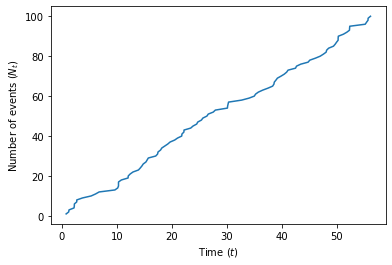

In [5]:
print('Initial event times:'+ str(process_path.list_times[0][:20]))
fig, ax = plt.subplots()
ax.plot(process_path.list_times[0][:100], np.arange(1,101))
ax.set_xlabel('Time ($t$)')
ax.set_ylabel('Number of events ($N_t$)')

**Estimation**

Next, we suppose only the event times data were given, and so define a new model (of the same type as the ground-truth), and estimate its parameters using the ASLSD algorithm. Here we use a constant learning rate in the ADAM optimizer.

In [6]:
# Define an exponential model
kernel = KernelModel(ExponentialKernel())
mhp = MHP([[kernel]])
kwargs = {'is_log_param': True, 'is_log_grad': True}

In [7]:
# Fit the parameters of the model
mhp.fit(process_path, n_iter=2000, seed=seed, verbose=True, **kwargs)
fit_log = mhp.fit_log

100%|██████████| 2000/2000 [12:18<00:00,  2.71it/s]


We plot the fitted (and ground-truth) kernel, and some goodness of fit plots.

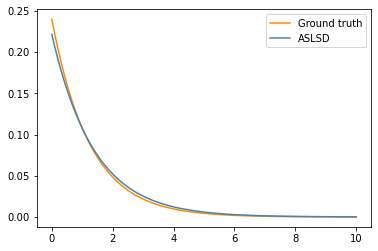

In [10]:
# Visualize results
fig, ax = plt.subplots()
t = np.linspace(0, 10, 1000)
true_y = true_mhp.phi[0][0](t, true_ker_param[0][0])
ax.plot(t, true_y, color='darkorange', label='Ground truth')
fitted_y = mhp.phi[0][0](t, mhp.fitted_ker_param[0][0])
ax.plot(t, fitted_y, color='steelblue', label='ASLSD')
ax.legend()

Finally, we can plot the path of the parameters taken by the solver.

array([[<AxesSubplot:ylabel='$μ$ updates'>,
        <AxesSubplot:ylabel='$μ$ derivative'>],
       [<AxesSubplot:ylabel='$ω$ updates'>,
        <AxesSubplot:ylabel='$ω$ derivative'>],
       [<AxesSubplot:xlabel='Iteration', ylabel='$β$ updates'>,
        <AxesSubplot:xlabel='Iteration', ylabel='$β$ derivative'>]],
      dtype=object)

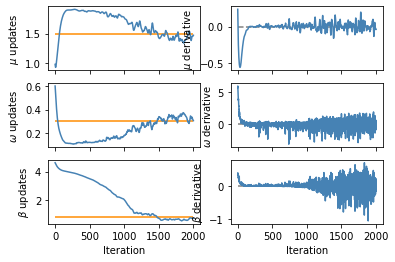

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False)
mhp.plot_solver_path(true_mu=true_mu, true_ker_param=true_ker_param,
                     plot_derivatives=True, derivatives_zero=True, axes=axes)